In [1]:
import pymc as pm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pandas as pd
import pytensor.tensor as pt
import json
import scipy.stats as stats

#Make sure it can see the system path

import sys
from pathlib import Path

PROJECT_ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

from utils import load_data,plot_helpers
from modeling import bayes,viz


In [2]:
for_paper=True
for_talk=False

if for_paper:

    import scienceplots #http://doi.org/10.5281/zenodo.4106649
    plt.style.use(('science','nature'))
elif for_talk:
    plt.style.use("dark-background")
else:
    az.style.use("arviz-doc")
    
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
from importlib import reload
reload(bayes)

<module 'modeling.bayes' from '/Users/kmarvel/Documents/CMIPBAYES/modeling/bayes.py'>

# Load the ECS data
ECS calculations from Zelinka et al 2020 

(https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019GL085782).


Code at:
https://github.com/mzelinka/cmip56_forcing_feedback_ecs


https://zenodo.org/badge/latestdoi/259409949

Text(0.5, 0, 'ECS (°C)')

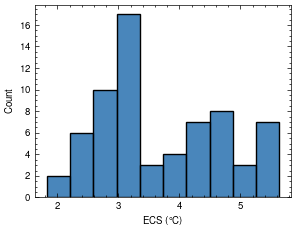

In [4]:

zelinka_ECS=load_data.load_feedback("ECS")

sns.histplot(zelinka_ECS.values, bins=10)
plt.xlabel("ECS (°C)")

# Which interpretive model for CMIP should we use?
### Fixed effects
Assumes each ensemble member $j$ of each Earth System Model's value of X is the true real-world value plus measurement noise: 

$X_i =X + \epsilon$

with 

$\epsilon \sim N(0,\sigma)$.
### Random effects
Assumes each ensemble member's X is the true (latent) value of X in that ESM plus ESM-specific internal variability:

$X^j_i = X_i + \epsilon_{i}$

with 


$\epsilon_{iv} \sim N(0,\sigma_i)$.

Additionally assumes each ESM's $X_i$ is a potentially biased representation of the real world:

$X_i = X + bias_{i} + bias_{shared}$

where $bias_i \sim N(0,\sigma_{struct})$.

### Correlated random effects.
If some (or all) of the bias is shared across models, the bias in model $i$ will be related to the bias in model $j$.  The variable $\rho$ measures the correlation in the bias beween any two ESMs. The correlated random effects model is then

$X_i^j \sim N(X_i, \sigma_i)\\
X_i \sim MVN(X,\Sigma)$
with


$\Sigma=\sigma_{struct} \begin{pmatrix}
1      & \rho  & \rho  & \cdots & \rho \\
\rho   & 1     & \rho  & \cdots & \rho \\
\rho   & \rho  & 1     & \cdots & \rho \\
\vdots & \vdots& \vdots& \ddots & \vdots \\
\rho   & \rho  & \rho  & \cdots & 1
\end{pmatrix}$

### Known sources of bias
For ECS, we'll assume we don't know where the ESM biases come from.  (This isn't a great assumption because we probably do know some of the process-based sources of bias: cloud parameterizations, inclusion/exclusion of various processes, etc.)  When we consider the terrestrial CO2 effect $\beta_L$ we'll show how to explicitly model process-based sources of bias.

### Flowchart
Following the chart, let's explore the differences in different assumptions about shared vs common model bias.

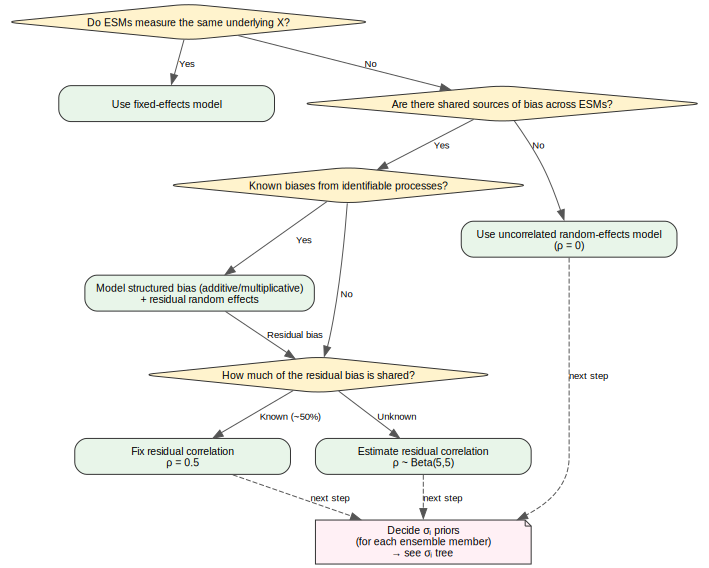

In [5]:
reload(viz)
viz.show_highlevel_tree("paper")
#plt.savefig("FIGS/Highleveltree.pdf")

### How do we think about internal variability?
For ECS, internal variability is negligible (but likely not exactly zero).  We don't have large model ensembles to estimate it at any rate.  So we'll set it to a constant across all ESMs.

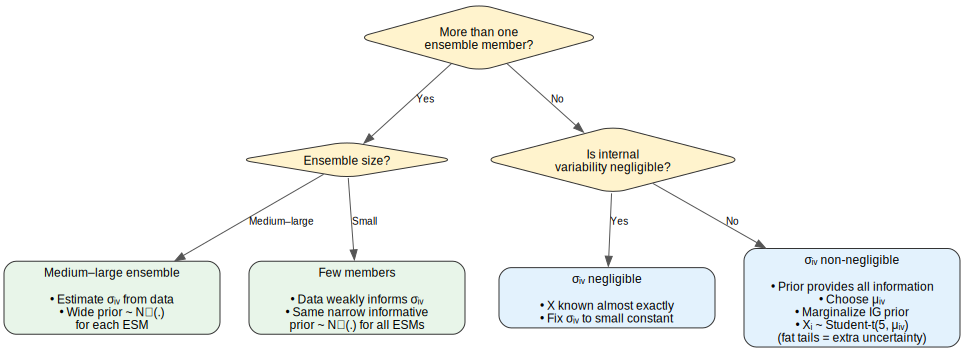

In [6]:
viz.show_iv_tree("jupyter")

# Random effects models for ECS
## Common priors for all models
Let's set $\sigma_{iv} = 0.01K$ and use an uninformative prior on ECS (you can change this as desired):

In [7]:
priors={"sigma_iv":lambda name: 0.01,\
       "ECS": lambda name: pm.Normal(name,0,10)}

#### Uncorrelated random effects
What if there's no source of common bias across the models? Then we can set $\rho=0$.  This is assuming the ESM ECS results are centered around the ``true" value.

In [8]:
priors0 = priors | {"rho": lambda name:0.0}
model0=bayes.build_correlated_random_effects_model(zelinka_ECS,\
                                            var_name="ECS",\
                                            priors=priors0)
with model0:
    trace0=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, ECS_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### Correlated random effects
What if 50% of the bias is explained by ESM-specific errors and 50% could be a common error shared across all ESMs?  In this case we set $\rho=0.5$.  This has the effect of widening the posterior, because the model can no longer treat extreme ECS values as an outliers (since the high/low ECS are now presumed to be partially reflective of biases common across all of CMIP).

In [9]:

priors05 = priors | {"rho": lambda name:0.5}
model05=bayes.build_correlated_random_effects_model(zelinka_ECS,\
                                            var_name="ECS",\
                                            priors=priors05)
with model05:
    trace05=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, ECS_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### But I don't know the biases!
If we don't know $\rho$, we can explore the uncertainty by using a relatively wide prior on $\rho$.  The default is $\rho \sim Beta(5,5)$- lots of mass around 0.5, less at 0 and 1.  Note that the uncertainty in $\rho$ is completely prior-dominated here.  The CMIP data itself can't tell us anything about the common/shared biases.  We place a prior on $\rho$ not to update it with data but to accurately sample the uncertainty, which will propagate through to the posterior for ECS.

In [41]:

modelrho=bayes.build_correlated_random_effects_model(zelinka_ECS,\
                                            var_name="ECS",\
                                            priors=priors)
with modelrho:
    tracerho=pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, rho, ECS_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


## Different modeling choices lead to different posteriors

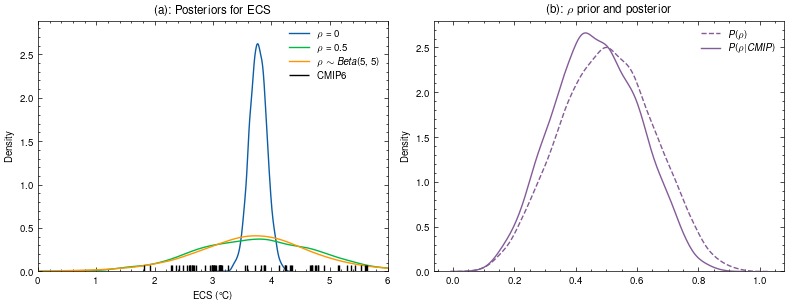

In [12]:
plt.figure(figsize=(8,3))
ax=plt.subplot(121)
plot_helpers.plot_posterior(trace0,"ECS",label=r"$\rho=0$",ax=ax)
plot_helpers.plot_posterior(trace05,"ECS", label=r"$\rho=0.5$",ax=ax)
plot_helpers.plot_posterior(tracerho,"ECS",label=r"$\rho \sim Beta(5,5)$",ax=ax)
sns.rugplot(zelinka_ECS,c="k",label="CMIP6")
plt.xlim(0,6)
plt.xlabel("ECS (°C)")
plt.legend()
ax2=plt.subplot(122)
sns.kdeplot(stats.beta(5,5).rvs(10000),c="k",ls="--",label=r"$P(\rho)$",color=colors[4])
plot_helpers.plot_posterior(tracerho,"rho",ax=ax2,c="k",label=r"$P(\rho| CMIP)$",color=colors[4])

plt.legend()
plt.tight_layout()
ax.set_title("(a): Posteriors for ECS")
ax2.set_title(r"(b): $\rho$ prior and posterior ")
plt.savefig("FIGS/ECS_CRE.pdf")

# Emergent constraints
Now, we want to use CMIP-derived emergent constraints to update these posteriors.   To illustrate, we'll use:
* BRI: Response of shortwave cloud reflectivity to changes in sea surface temperature [% K−1]
* ZHA: Response of seasonal marine boundary layer cloud fraction to change in sea surface temperature [% K−1]
## CMIP data
CMIP5 and 6 emergent constraints are taken from Schund et al: https://esd.copernicus.org/articles/11/1233/2020/#section7
## Observations
* From Brient and Schneider: Response of SW cloud reflectivity to SST changes is (-0.96+=0.22) (90%CL) https://journals.ametsoc.org/view/journals/clim/29/16/jcli-d-15-0897.1.xml

* From Zhai: ±3σ (standard error) (0.56%/K) around the observed αseason of -1.28 K. https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2015GL065911

## Some emergent constraints are more constraining than others
The relationship between BRI and CMIP6 ECS is much weaker than ZHA and CMIP6 ECS. So BRI is much less informative about ECS than ZHA. 

In [13]:
EC=load_data.emergent_constraints("CMIP6")
mask=~np.isnan(EC.ZHA)
np.corrcoef(EC.ZHA.values[mask],EC.ECS.values[mask])

array([[ 1.       , -0.7888983],
       [-0.7888983,  1.       ]])

In [14]:
with bayes.simple_ec_model("BRI"):
    britrace=pm.sample(target_accept=.99)

with bayes.simple_ec_model("ZHA"):
    zhatrace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, m, b, sigma_reg]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, m, b, sigma_reg]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Note that this is different from reported in Schlund et al, which uses OLS.  That method assumes a) all uncertainty is in ECS, none in the observable b) the observable is measured without error in the fitting regression c) the regression slope is fixed and known after OLS fitting.  Schlund et al answer the question "what ECS would we predict if the observable were equal to the observed value?".  I'm asking "what ECS values are consistent with the observed under an assumed linear model?"  This method correctly propagates uncertainty and penalizes weak constraints.

/Users/kmarvel/Documents/CMIPBAYES/utils/plot_helpers.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(Y, hdi_prob=hdi_prob)
/Users/kmarvel/Documents/CMIPBAYES/utils/plot_helpers.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(Y, hdi_prob=hdi_prob)


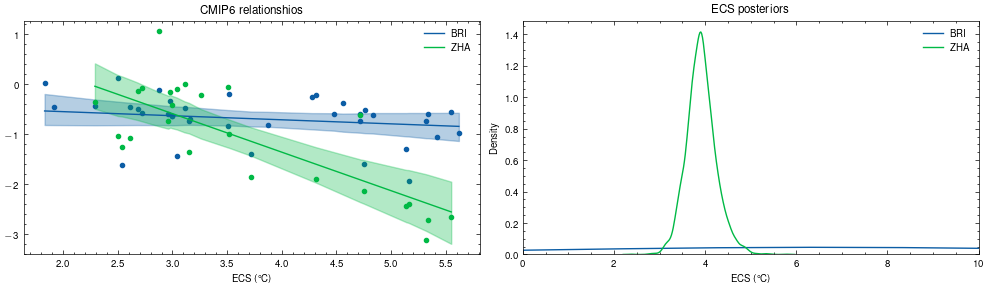

In [20]:
fig=plt.figure(figsize=(10,3))
ax=plt.subplot(121)
ax.set_title("CMIP6 relationshios")
bridata=load_data.prep_EC_data("BRI")
plot_helpers.plot_posterior_hdi_mXb(britrace,bridata["X"],ax=ax,label="BRI",color=colors[0])
#plot_posterior_hdi_mXb(zhatrace,CMIP6.ECS.values)
plt.scatter(bridata["X"],bridata["Y"],color=colors[0])

zhadata=load_data.prep_EC_data("ZHA")
plot_helpers.plot_posterior_hdi_mXb(zhatrace,zhadata["X"],ax=ax,color=colors[1],label="ZHA")
#plot_posterior_hdi_mXb(zhatrace,CMIP6.ECS.values)
plt.scatter(zhadata["X"],zhadata["Y"],color=colors[1])
plt.legend()
ax.set_xlabel("ECS (°C)")
ax.set_ylabel("%/K")

ax2=plt.subplot(122)
plot_helpers.plot_posterior(britrace,"ECS",ax=ax2,label="BRI",color=colors[0])
plot_helpers.plot_posterior(zhatrace,"ECS",ax=ax2,label="ZHA",color=colors[1])
ax2.set_xlim(0,10)
ax2.set_xlabel("ECS (°C)")
ax2.legend()

plt.title("ECS posteriors")
plt.tight_layout()
plt.savefig("FIGS/EmergentConstraints.pdf")

In [26]:
az.summary(zhatrace,hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ECS,3.914,0.325,3.302,4.587,0.007,0.005,2524.0,1764.0,1.0
m,-0.771,0.142,-1.058,-0.495,0.004,0.003,1504.0,1897.0,1.0
b,1.729,0.527,0.670,2.741,0.014,0.010,1521.0,1956.0,1.0
sigma_reg,0.710,0.109,0.520,0.932,0.002,0.002,2450.0,2113.0,1.0


##  Adding an emergent constraint to a random effects model

We don't want to double-count CMIP data- we're using it to get P(X|CMIP), and then we're using it again to get P(X|Observable) via a regression. The solution is to build a joint model where we let the CMIP data and our assumptions about its relationship to truth inform P(X|CMIP) and then use the CMIP data to get posteriors for the slope and intercept of the best-fit line.

In [27]:
observable_var_name="BRI"
data=load_data.prep_EC_data(observable_var_name)

brituple=("ECS",\
        observable_var_name,\
        data["Y"], #observable in CMIP
        data["Y_obs"], #observable obs
         data["sigma_Y"] #observable uncertainty
        )



A Bayesian emergent constraint model respects causality.  ECS is the underlying quantity we care about.  Y (BRI, ZHA, whatever) is the response: an observable that depends on X.  Causally we assume the true ECS implies the observed Y: the response $Y$ is conditionally dependent on X and not the other way around.  This is a rather indirect way of saying "whatever characteristics (processes, parameterizations etc.) that make an ESM simulate a particular ECS will cause the same ESM to simulate a particular Y.  Therefore, the real world, with its real processes, will have a certain ECS, and this will cause the real world Y to take its observed value"."

In [ ]:
with modelrho:
    bayes.add_emergent_constraint(modelrho,*brituple)
    rhobri=pm.sample()

# Adding additional ECs
Let's add the Zha emergent constraint to our model.

In [ ]:
observable_var_name="ZHA"
data=load_data.prep_EC_data(observable_var_name)

zhatuple=("ECS",\
        observable_var_name,\
        data["Y"], #observable in CMIP
        data["Y_obs"], #observable obs
         data["sigma_Y"] #observable uncertainty
        )

In [46]:
with modelrho:
    bayes.add_emergent_constraint(modelrho,*zhatuple)
    rhotwo=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, rho, ECS_CMIP, m_BRI, b_BRI, regression_sigma_BRI, m_ZHA, b_ZHA, regression_sigma_ZHA]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


/Users/kmarvel/Documents/CMIPBAYES/utils/plot_helpers.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(Y, hdi_prob=hdi_prob)
/Users/kmarvel/Documents/CMIPBAYES/utils/plot_helpers.py:89: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(Y, hdi_prob=hdi_prob)


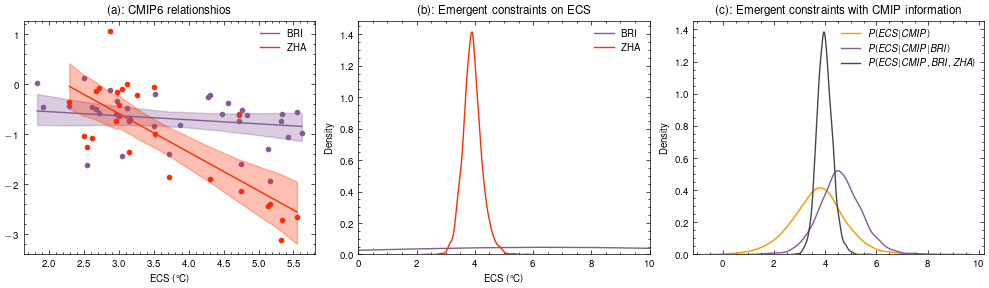

In [53]:
fig=plt.figure(figsize=(10,3))
ax=plt.subplot(131)
ax.set_title("(a): CMIP6 relationshios")
bridata=load_data.prep_EC_data("BRI")
plot_helpers.plot_posterior_hdi_mXb(britrace,bridata["X"],ax=ax,label="BRI",color=colors[4])
#plot_posterior_hdi_mXb(zhatrace,CMIP6.ECS.values)
plt.scatter(bridata["X"],bridata["Y"],color=colors[4])

zhadata=load_data.prep_EC_data("ZHA")
plot_helpers.plot_posterior_hdi_mXb(zhatrace,zhadata["X"],ax=ax,color=colors[3],label="ZHA")
#plot_posterior_hdi_mXb(zhatrace,CMIP6.ECS.values)
plt.scatter(zhadata["X"],zhadata["Y"],color=colors[3])
plt.legend()
ax.set_xlabel("ECS (°C)")
ax.set_ylabel("%/K")

ax2=plt.subplot(132)
plot_helpers.plot_posterior(britrace,"ECS",ax=ax2,label="BRI",color=colors[4])
plot_helpers.plot_posterior(zhatrace,"ECS",ax=ax2,label="ZHA",color=colors[3])
ax2.set_xlim(0,10)
ax2.set_xlabel("ECS (°C)")
ax2.legend()

plt.title("(b): Emergent constraints on ECS")
plt.tight_layout()


ax3=plt.subplot(133)
plot_helpers.plot_posterior(tracerho,"ECS",color=colors[2],ax=ax3,label=r"$P(ECS|CMIP)$")
plot_helpers.plot_posterior(rhobri,"ECS",ax=ax3,color=colors[4],label=r"$P(ECS|CMIP|BRI)$")
plot_helpers.plot_posterior(rhotwo,"ECS",ax=ax3,color=colors[5],label=r"$P(ECS|CMIP,BRI, ZHA)$")
plt.legend()
plt.title("(c): Emergent constraints with CMIP information")
plt.savefig("FIGS/EmergentConstraints.pdf")

# SCRATCHWORK: Toward process-based constraints
BRI is more correlated with SWCLD than ECS.  Let's first build a modular framework for incorporating multiple CREs

In [ ]:
allf=np.array([zelinka[fb].values for fb in feedbacks])
netf=np.sum(allf,axis=0)
erf=zelinka["ERF2x"].values
plt.hist(-erf/netf)

In [ ]:
plt.hist(zelinka["ERR"])

In [ ]:
zelinka=load_data.feedback_dictionary()
feedbacks= ["PL*","LR*","RH","ALB","SWCLD","LWCLD"]
lambda_data=np.array([zelinka[fb].values for fb in feedbacks])
erf_data=zelinka["ERF2x"].values


In [ ]:
coords={"feedback":feedbacks,\
       "model":zelinka["ERF2x"].model.data}